CVの切り方検討メモ
* 単純にtime seriesだと、例えば、trainとvalid 両方に20年第1四半期 が混ざることがありうる。
* 実際のtestデータは 四半期が区切られているので、↑はあんまり望ましくない?
* 上記より、自前でTimeSeriesのCVを作ってあげる

In [1]:
from calendar import month_name
from contextlib import contextmanager
from glob import glob
import inspect
from itertools import product
import os
import re
from sre_constants import CATEGORY_SPACE
import sys
from pathlib import Path
from time import time
from typing import Iterable, Optional, Union

import category_encoders as ce
import lightgbm as lgbm
from IPython.display import display
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, StratifiedGroupKFold, GroupKFold, RepeatedKFold, TimeSeriesSplit
import sweetviz as sv
from tqdm import tqdm

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 200)

/tmp/ipykernel_3976/1987612431.py:8: DeprecationWarning: module 'sre_constants' is deprecated
  from sre_constants import CATEGORY_SPACE


# CFG

In [2]:
class CFG:
    """ Config

        input folder , output folderを作成し、
        提出用csvに名前をつけてouput folderに格納

    """

    n_fold = 5
    n_repeated_fold = 3
    seed = 42
    TARGET = '取引価格（総額）_log'
    exp_folder_name = "exp002/"
    exp_name = "exp2_time-series-split_by_sklearn-drop-feature"
    INPUT_DIR = Path("../input")
    OUTPUT_DIR = Path("../output/0_chanzon-khm/")
    EXP_DIR = os.path.join(OUTPUT_DIR, exp_folder_name)
    

os.makedirs(CFG.OUTPUT_DIR, exist_ok=True)
os.makedirs(CFG.EXP_DIR, exist_ok=True)

# Utils

In [3]:
class Timer:
    def __init__(
        self,
        logger=None,
        format_str="{:.3f}[s]",
        prefix=None,
        suffix=None,
        sep=" ",
        verbose=0,
    ):

        if prefix:
            format_str = str(prefix) + sep + format_str
        if suffix:
            format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None
        self.verbose = verbose

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):  # withステートメントが実行されたときに initの次に実行される
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):  # withステートメントの実行が終わるときに最後に実行される
        self.end = time()
        if self.verbose is None:
            return
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)


def decorate(s: str, decoration=None):
    if decoration is None:
        decoration = "★" * 20

    return " ".join([decoration, str(s), decoration])


def param_to_name(params: dict, key_sep="_", key_value_sep="=") -> str:
    """
    dict を `key=value` で連結した string に変換します.
    Args:
        params:
        key_sep:
            key 同士を連結する際に使う文字列.
        key_value_sep:
            それぞれの key / value を連結するのに使う文字列.
            `"="` が指定されると例えば { 'foo': 10 } は `"foo=10"` に変換されます.
    Returns:
        文字列化した dict
    """
    sorted_params = sorted(params.items())
    return key_sep.join(map(lambda x: key_value_sep.join(map(str, x)), sorted_params))


def cachable(function):
    attr_name = "__cachefile__"

    def wrapper(*args, **kwrgs):
        force = kwrgs.pop("force", False)
        call_args = inspect.getcallargs(function, *args, **kwrgs)

        arg_name = param_to_name(call_args)
        name = attr_name + arg_name

        use_cache = hasattr(function, name) and not force

        if use_cache:
            cache_object = getattr(function, name)
        else:
            print("run")
            cache_object = function(*args, **kwrgs)
            setattr(function, name, cache_object)

        return cache_object

    return wrapper


@cachable
def read_csv(name):

    if ".csv" not in name:
        name = name + ".csv"

    return pd.read_csv(os.path.join(CFG.INPUT_DIR, name))

@cachable
def read_pkl(name):

    if ".pkl" not in name:
        name = name + ".pkl"

    return pd.read_pickle(os.path.join(CFG.INPUT_DIR, name))

# read data

In [4]:
paths = glob(os.path.join(CFG.INPUT_DIR,'train/*'))
train_dfs = []
for path in paths:
    _df = pd.read_csv(path)
    train_dfs.append(_df)
del _df
train_all_df = pd.concat(train_dfs)
train_all_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'test.csv'))

/tmp/ipykernel_3976/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)
/tmp/ipykernel_3976/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)
/tmp/ipykernel_3976/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)
/tmp/ipykernel_3976/601101742.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(path)


# EDA

In [5]:
train_all_df.shape, test_df.shape

((779404, 28), (18394, 27))

In [6]:
train_all_df.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', '取引価格（総額）_log'],
      dtype='object')

## 数値データ列に混在する文字列の前処理

In [7]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(float(moyori))
    return moyori

In [8]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [9]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [10]:
train_all_df['建築年'] = train_all_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
test_df['建築年'] = test_df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
train_all_df['面積（㎡）'] = train_all_df['面積（㎡）'].apply(lambda x: normalize_area(x))
test_df['面積（㎡）'] = test_df['面積（㎡）'].apply(lambda x: normalize_area(x))
train_all_df['最寄駅：距離（分）'] = train_all_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
test_df['最寄駅：距離（分）'] = test_df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))

enc_dic = {}
all_df = pd.concat([train_all_df, test_df])

for i, e in enumerate(sorted(list(set(all_df['取引時点'].values)))):
    enc_dic[e] = i
all_df['取引時点_enc'] = all_df['取引時点'].map(enc_dic)


# 欠損列を削除
rm_cols = []
for i,v in all_df.nunique().items():
    if v <= 1:
        rm_cols.append(i)

all_df.drop(rm_cols, axis=1, inplace=True)
        

all_df[all_df['取引価格（総額）_log'].notnull()].copy().to_csv('train_all.csv', index=False, header=True)
all_df[all_df['取引価格（総額）_log'].isnull()].copy().to_csv('test.csv', index=False, header=True)



## sweetviz

In [11]:
# import sweetviz as sv
# sv.config_parser.read("../sweetviz_settings/sweetviz_settings.ini") # 1回目の実行だとなぜか日本語文字化けする・・?

In [12]:
# import sweetviz as sv
# my_report = sv.compare([train_all_df, 'train'], [test_df, "test"], CFG.TARGET)
# sv.config_parser.read("../sweetviz_settings/sweetviz_settings.ini")
# my_report.show_html("sweetviz_report2.html")

## データの確認

In [13]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 797798 entries, 0 to 18393
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            797798 non-null  int64  
 1   市区町村コード       797798 non-null  int64  
 2   都道府県名         797798 non-null  object 
 3   市区町村名         797798 non-null  object 
 4   地区名           797123 non-null  object 
 5   最寄駅：名称        794997 non-null  object 
 6   最寄駅：距離（分）     774571 non-null  float64
 7   間取り           767447 non-null  object 
 8   面積（㎡）         797798 non-null  int64  
 9   建築年           774523 non-null  float64
 10  建物の構造         774589 non-null  object 
 11  用途            707489 non-null  object 
 12  今後の利用目的       428917 non-null  object 
 13  都市計画          776902 non-null  object 
 14  建ぺい率（％）       772172 non-null  float64
 15  容積率（％）        772172 non-null  float64
 16  取引時点          797798 non-null  object 
 17  改装            718365 non-null  object 
 18  取引の事情等    

# 読み込みデータ整理


In [14]:

@cachable
def read_train_all_df():
    return pd.read_csv('train_all.csv')

@cachable
def read_test_df():
    return pd.read_csv('test.csv')


@cachable
def read_whole_df():
    whole_df = pd.concat([read_train_all_df(),read_test_df()], ignore_index=True)
    return whole_df.sort_values('取引時点').reset_index(drop=True)

train_all_df = read_train_all_df()
test_df = read_test_df()
whole_df = read_whole_df()

# 後で、train,valid分割ように、取引時点の時系列に並び替えたい
train_all_df = whole_df[whole_df['取引価格（総額）_log'].notnull()].copy()
test_df = whole_df[whole_df['取引価格（総額）_log'].isnull()].copy()

run


run
run


## AbstractBaseBlock

In [15]:
class AbstractBaseBlock:
    def fit(self, input_df: pd.DataFrame, y=None):
        return self.transform(input_df)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError()

In [16]:
class NumericBlock(AbstractBaseBlock):
    def __init__(self, column):
        self.column = [column]

    def transform(self, input_df):
        return input_df[self.column].copy()

In [17]:
# 表記ゆれの処理

# class NormalizeMoyori(AbstractBaseBlock):
#     def __init__(self, column):
#         self.column = column
    
#     def transform(self, input_df):
#         out_df = pd.DataFrame()
#         out_df[self.column] = input_df[self.column].apply(lambda x: self.normalize_moyori(x))

#         return out_df.add_prefix(f'pp_')
    
#     @staticmethod
#     def normalize_moyori(moyori):
#         if moyori == moyori:
#             if moyori == '30分?60分':
#                 moyori = 45
#             elif moyori == '1H?1H30':
#                 moyori = 75
#             elif moyori == '1H30?2H':
#                 moyori = 105
#             elif moyori == '2H?':
#                 moyori = 120
                                
#             moyori = int(float(moyori))
        
#         return moyori
    

# class NormalizeArea(AbstractBaseBlock):
#     def __init__(self, column):
#         self.column = column
        
#     def transform(self, input_df):
#         out_df = pd.DataFrame()
#         out_df[self.column] = input_df[self.column].apply(lambda x: self.normalize_area(x))
        
#         return out_df.add_prefix(f'pp_')
    
#     @staticmethod
#     def normalize_area(area):
#         if area == area:
#             area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
#         return area


# class CovertWarekiToSeireki(AbstractBaseBlock):
#     def __init__(self, column):
#         self.column = column
        
#     def transform(self, input_df):
#         out_df = pd.DataFrame()
#         out_df[self.column] = input_df[self.column].apply(lambda x: self.convert_wareki_to_seireki(x))
#         return out_df.add_prefix(f'pp_')
    
#     @staticmethod
#     def convert_wareki_to_seireki(wareki):
#         if wareki == wareki:
#             if wareki == '戦前':
#                 wareki = '昭和20年'
#             value = wareki[2:-1]
#             if value == '元':
#                 value = 1
#             else:
#                 value = int(value)
#             if '昭和' in wareki:
#                 seireki = 1925+value
#             elif '平成' in wareki:
#                 seireki = 1988+value
#             elif '令和' in wareki:
#                 seireki = 2018+value
#         else:
#             seireki = wareki
#         return seireki

In [18]:
class OneHotEncoding(AbstractBaseBlock):
    def __init__(self, column, min_count=30):
        self.column = column
        self.min_count = min_count

    def fit(self, input_df, y=None):
        x = input_df[self.column]
        vc = x.value_counts()
        categories = vc[vc > self.min_count].index
        self.categories_ = categories

        return self.transform(input_df)

    def transform(self, input_df):
        x = input_df[self.column]
        cat = pd.Categorical(x, categories=self.categories_)
        out_df = pd.get_dummies(cat, drop_first=True)
        out_df.columns = out_df.columns.tolist()
        out_df.index = input_df.index.tolist() # indexが飛び飛びのデータの場合、このブロックではindex振り直しになるため、run_blocksのconcatでおかしくなるため
        return out_df.add_prefix(f"{self.column}=")

In [19]:
class LabelEncoding(AbstractBaseBlock):
    def __init__(self, column):
        self.column = column
        self.encoder = LabelEncoder()

    def fit(self, input_df, y=None):
        self.encoder.fit(input_df[self.column])
        
        return self.transform(input_df)

    def transform(self, input_df):
        out_df = input_df[[self.column]].copy()

        
        # 既知のラベルのリストを取得
        known_labels = self.encoder.classes_

        # 未知のラベルを持つ行を特定
        unknown_mask = ~out_df[self.column].isin(known_labels)
        # 未知のラベルを持つ行に-999を設定
        out_df.loc[unknown_mask, self.column] = -999

        # 未知のラベルの行以外のエントリにtransformを適用
        known_mask = ~unknown_mask & out_df[self.column].notnull()
        out_df.loc[known_mask, self.column] = \
            self.encoder.transform(out_df[known_mask][self.column])

        out_df.fillna(-99, inplace=True)
        out_df[self.column] = out_df[self.column].astype('int64')
        return out_df.add_prefix(f"LE_")


In [20]:
class MeanOfCol_ruikei(AbstractBaseBlock):
    def __init__(self, group_col):
        self.te_dic = {}
        self.time_col = '取引時点_enc'
        self.group_col = group_col
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        whole_df = read_whole_df()
        
        for i in set(whole_df[self.time_col].values):
            tmp_df = whole_df[whole_df[self.time_col] < i]
            self.te_dic[i] = tmp_df.groupby(self.group_col)[CFG.TARGET].agg('mean').to_dict()
            
        out_df[self.group_col] = input_df.apply(self.calc_te, axis=1)

        return out_df
    
    def calc_te(self, row):
        if row[self.time_col] in self.te_dic and row[self.group_col] in self.te_dic[row[self.time_col]]:
            return self.te_dic[row[self.time_col]][row[self.group_col]]
        else:
            return np.nan


In [21]:
class BeforeYearTraded(AbstractBaseBlock):
    def __init__(self, year):
        self.year = year
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[f'{self.year}-取引時点'] = input_df['取引時点'].apply(lambda x: self.year-int(x[:4]))
        return out_df
        

In [22]:
class GetCombi(AbstractBaseBlock):
    def __init__(self, columns:list):
        """
        特徴量を2つ指定 掛け算
        """
        self.columns = columns
        
        
    def transform(self, input_df):
        out_df = pd.DataFrame()
        if "％" in self.columns[0]:
            col1 = (input_df[self.columns[0]] / 100).copy()
        else:
            col1 = input_df[self.columns[0]].copy()
        if "％" in self.columns[1]:
            col2 = (input_df[self.columns[1]] / 100).copy()
        else:
            col2 = input_df[self.columns[1]].copy()
            
        new_col_name = f'combi_{self.columns[0]} * {self.columns[1]}'
        
        out_df[new_col_name] = col1 * col2
        return out_df
    

In [23]:
# 本来なら、trainデータで集計した値をtestに当てはめるべき
class GetAggDf(AbstractBaseBlock):
    def __init__(self, group_col):
        self.group_col = group_col
    
    
    def transform(self, input_df):
        agg_cols = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
        out_df = pd.DataFrame()
        whole_df = read_whole_df()
        functions = ["count", "mean", "min", "max"]
        for col, function in product(agg_cols, functions): # productを使うと 2つの引数のすべての組み合わせを返す ex 最寄駅：距離（分） count ,  最寄駅：距離（分） mean 最寄駅：距離（分） min
            col_name = f"{col}_{function}"
            out_df[col_name] = whole_df.groupby(self.group_col)[col].transform(function) # transform()を使うと、groupbyで集計したデータを元データに結合できる
    
        if len(input_df) > 20000:
            tr_idx = whole_df[whole_df[CFG.TARGET].notnull()].index
            return out_df.loc[tr_idx, :]
        
        else:
            ts_idx = whole_df[whole_df[CFG.TARGET].isnull()].index
            return out_df.loc[ts_idx, :]


## run blocks

In [24]:
def run_blocks(input_df, blocks, y=None, test=False):
    out_df = pd.DataFrame()

    print(decorate('start run blocks...'))

    with Timer(prefix='run test={}'.format(test)):
        for block in blocks:
            with Timer(prefix='\t- {}'.format(str(block))):
                if not test:
                    out_i = block.fit(input_df, y=y)
                else:
                    out_i = block.transform(input_df)

            assert len(input_df) == len(out_i), block
            name = block.__class__.__name__
            out_df = pd.concat([out_df, out_i.add_suffix(f'@{name}')], axis=1)

    return out_df

In [25]:
num_cols = train_all_df.select_dtypes('number')
num_cols.drop([CFG.TARGET, 'ID'], axis=1, inplace=True)

cat_cols = train_all_df.select_dtypes('object')

group_cols = ['都道府県名']
before_year_trade_list = [2021]

get_combi_cols = [["面積（㎡）", "容積率（％）"]]

In [26]:
feature_blocks = [
    *[NumericBlock(c) for c in num_cols],
    *[LabelEncoding(c) for c in cat_cols],
    *[MeanOfCol_ruikei(c) for c in group_cols],
    *[BeforeYearTraded(c) for c in before_year_trade_list],
    # *[GetCombi(c) for c in get_combi_cols],
    *[GetAggDf(c) for c in group_cols],
    
]


In [27]:
train_feat_df = run_blocks(input_df = train_all_df, blocks=feature_blocks, y=None, test=False)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.NumericBlock object at 0x7fde8369e250> 0.003[s]
	- <__main__.NumericBlock object at 0x7fde8367b610> 0.004[s]
	- <__main__.NumericBlock object at 0x7fde83325210> 0.003[s]
	- <__main__.NumericBlock object at 0x7fde836a7f10> 0.005[s]
	- <__main__.NumericBlock object at 0x7fde836a6290> 0.005[s]
	- <__main__.NumericBlock object at 0x7fde836a5290> 0.004[s]
	- <__main__.NumericBlock object at 0x7fde836a7190> 0.005[s]
	- <__main__.LabelEncoding object at 0x7fde836a5d90> 0.428[s]
	- <__main__.LabelEncoding object at 0x7fde836a5c10> 0.394[s]


	- <__main__.LabelEncoding object at 0x7fde836a6b90> 0.908[s]
	- <__main__.LabelEncoding object at 0x7fde836a6cd0> 0.736[s]
	- <__main__.LabelEncoding object at 0x7fde836a4b10> 0.459[s]
	- <__main__.LabelEncoding object at 0x7fde836a5bd0> 0.408[s]
	- <__main__.LabelEncoding object at 0x7fde836a6610> 0.457[s]
	- <__main__.LabelEncoding object at 0x7fde836a6f90> 0.363[s]
	- <__main__.LabelEncoding object at 0x7fde836a7cd0> 0.510[s]
	- <__main__.LabelEncoding object at 0x7fde836a56d0> 0.370[s]
	- <__main__.LabelEncoding object at 0x7fde836a5010> 0.482[s]
	- <__main__.LabelEncoding object at 0x7fde836a5b90> 0.402[s]
	- <__main__.MeanOfCol_ruikei object at 0x7fde836a6dd0> 23.857[s]
	- <__main__.BeforeYearTraded object at 0x7fde842238d0> 0.469[s]
	- <__main__.GetAggDf object at 0x7fde836a65d0> 1.447[s]
run test=False 32.241[s]


In [28]:
train_feat_df

,市区町村コード@NumericBlock,最寄駅：距離（分）@NumericBlock,面積（㎡）@NumericBlock,建築年@NumericBlock,建ぺい率（％）@NumericBlock,容積率（％）@NumericBlock,取引時点_enc@NumericBlock,LE_都道府県名@LabelEncoding,LE_市区町村名@LabelEncoding,LE_地区名@LabelEncoding,LE_最寄駅：名称@LabelEncoding,LE_間取り@LabelEncoding,LE_建物の構造@LabelEncoding,LE_用途@LabelEncoding,LE_今後の利用目的@LabelEncoding,LE_都市計画@LabelEncoding,LE_取引時点@LabelEncoding,LE_改装@LabelEncoding,LE_取引の事情等@LabelEncoding,都道府県名@MeanOfCol_ruikei,2021-取引時点@BeforeYearTraded,最寄駅：距離（分）_count@GetAggDf,最寄駅：距離（分）_mean@GetAggDf,最寄駅：距離（分）_min@GetAggDf,最寄駅：距離（分）_max@GetAggDf,面積（㎡）_count@GetAggDf,面積（㎡）_mean@GetAggDf,面積（㎡）_min@GetAggDf,面積（㎡）_max@GetAggDf,建ぺい率（％）_count@GetAggDf,建ぺい率（％）_mean@GetAggDf,建ぺい率（％）_min@GetAggDf,建ぺい率（％）_max@GetAggDf,容積率（％）_count@GetAggDf,容積率（％）_mean@GetAggDf,容積率（％）_min@GetAggDf,容積率（％）_max@GetAggDf
0,13114,NaN,40,2005.0,60.0,150.0,0,26,40,621,3175,19,4,6,-99,9,0,-99,-99,NaN,16,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
1,13104,NaN,55,2005.0,60.0,300.0,0,26,322,11924,3777,27,-99,6,-99,8,0,1,-99,NaN,16,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
2,23107,8.0,70,1995.0,80.0,300.0,0,24,149,5622,1720,39,4,6,-99,14,0,0,-99,NaN,16,37452,12.731790,0.0,120.0,38198,68.011807,10,790,37541,66.164194,30.0,80.0,37541,276.277670,50.0,1000.0
3,13119,16.0,50,1969.0,60.0,200.0,0,26,370,9911,192,33,4,6,-99,8,0,1,-99,NaN,16,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
4,14135,6.0,45,1967.0,NaN,NaN,0,32,280,322,2724,19,4,6,-99,-99,0,1,4,NaN,16,108822,13.497978,0.0,120.0,112773,58.445639,10,1100,106612,65.441039,30.0,80.0,106612,257.477301,50.0,1200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779399,13103,11.0,70,2015.0,60.0,400.0,67,26,440,9803,2742,39,4,6,2,6,67,1,-99,7.409042,-1,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
779400,12103,19.0,80,1984.0,60.0,200.0,67,5,119,4811,2932,39,8,-99,2,10,67,0,-99,7.170546,-1,40536,13.473752,0.0,120.0,41171,68.690462,10,880,39273,62.814402,30.0,80.0,39273,226.051740,60.0,900.0
779401,27224,13.0,70,1982.0,60.0,200.0,67,9,320,2517,835,-99,8,6,2,11,67,-99,-99,7.191502,-1,89968,9.091244,0.0,120.0,91825,60.098938,10,2000,90635,70.439234,40.0,80.0,90635,335.637668,80.0,1300.0
779402,27123,13.0,55,1988.0,80.0,300.0,67,9,214,6548,3240,27,8,6,2,10,67,1,-99,7.191502,-1,89968,9.091244,0.0,120.0,91825,60.098938,10,2000,90635,70.439234,40.0,80.0,90635,335.637668,80.0,1300.0


# model

In [29]:
# memo 
# time seriesのときは、 KFOLD用のoofはできない
def fit_lgbm_regressor(
    X: np.ndarray,
    y: np.ndarray,
    cv: Iterable,
    y_max: Optional[float] = None,
    params: Optional[dict] = None,
    callbacks: Optional[list] = None,
    verbose: Optional[int] = 50,
    n_repeats = None
):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}
    is_silent = verbose is None
    is_cut_y = y_max is not None  # yの上限が有る場合は上限値を指定し上限以上の値は丸め込み
    
    if n_repeats is not None:
        n_splits = len(cv) / n_repeats
        
    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=float)
    oof_preds = [] # repeated kfold 使う時用
    rmse_scores = []
    r2_scores = []
    for i, (idx_train, idx_valid) in enumerate(cv):
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        # 最大値が決まっている場合, 学習するデータだけ丸めを行なう
        if is_cut_y:
            idx_use = y_train < y_max
            y_train = np.where(idx_use, y_train, y_max)
        model = lgbm.LGBMRegressor(**params)
        
        print(decorate(f"fit fold = {i}"))
        with Timer(prefix="fit fold={} ".format(i), verbose=verbose):
            model.fit(
                x_train,
                y_train,
                eval_set=[(x_valid, y_valid)],
                callbacks = callbacks
            )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i # ToDo Repeated KFOLDのときは、最後のK-FOLDのデータがoofと
        models.append(model)
        # print(oof_pred)
        # foldごとに結果を出力
        if not is_silent:
            y_train_preds = model.predict(x_train)
            print(f"Fold {i} train R2-score: {r2_score(y_train, y_train_preds)}") 
            print(f"Fold {i} valid R2-score: {r2_score(y_valid, pred_i)}") 
            print(f"Fold {i} train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_preds))}") 
            print(f"Fold {i} valid RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i))}") 
            print(f"Fold {i} train MAE: {mean_absolute_error(y_train, y_train_preds)}") 
            print(f"Fold {i} valid MAE: {mean_absolute_error(y_valid, pred_i)}") 


        # RepeatedKFold のリピート毎にデータごとに結果を取得&出力
        if n_repeats is not None:
            if (i + 1) % n_splits == 0:
                oof_preds.append(oof_pred)
                rmse = np.sqrt(mean_squared_error(y, oof_pred))
                r2 = r2_score(y, oof_pred)
                print(decorate(f"Repeated No = {n_repeats} is fin"))
                print('Whole valid RMSE: {:.4f}'.format(rmse))
                print('Whole valid r2_score: {:.4f}'.format(r2))
                print('----------------------------------------')
                # リピートが終わったら初期化 ※初期化しない場合はデータが上書きされるので、oof_predsは値を参照しているので、最初にappendしたデータも更新されてしまう
                oof_pred = np.zeros_like(y, dtype=float)
    
    # 全体のスコアを返す。 RepeatedKFoldのときは、RepeatごとのWholeスコアの平均 TODO 計算おかしいくね?
    # if not is_silent:
    #     if n_repeats is None:
    #         rmse = np.sqrt(mean_squared_error(y, oof_pred))
    #         r2 = r2_score(y, oof_pred)
    #         mae = mean_absolute_error(y, oof_pred)
    #         print('Whole valid r2_score: {:.4f}'.format(r2))
    #         print('Whole valid RMSE: {:.4f}'.format(rmse))
    #         print('Whole valid MAE: {:.4f}'.format(mae))

    #     else:
    #         # まだ実装してない
    #         mean_oof_preds = np.mean(oof_preds, axis=0)
    #         rmse = np.sqrt(mean_squared_error(y, mean_oof_preds))
    #         r2 = r2_score(y, mean_oof_preds)
    #         print('Repeated Whole valid RMSE: {:.4f}'.format(rmse))
    #         print('Repeated Whole valid r2_score: {:.4f}'.format(r2))
    
    if n_repeats is None:
        return oof_pred, models
    else:
        return oof_preds, models

# CV関数

testと同じ用に未知の 2つの四半期を推測する。  
単純に、以下でやってみる
1. train : ~20/4Q valid : 21/2Q 21/3Q
2. train : ~21/1Q valid : 21/1Q 21/2Q
3. train : ~21/2Q valid : 21/3Q 21/4Q
4. train : ~21/3Q valid : 21/4Q 22/1Q
5. train : ~21/4Q valid : 22/1Q 22/2Q
   


In [30]:
def time_rolling_split(df, target_col="取引時点_enc", fold=5, test_size=2):
    """spl 
    取引時点_enc について time_series splitする。
    test_size = 2 なら testの取引時点_encが2つになるように切っていく
    以下イメージ
    
    train 0~66 test 67,68
    train 0~65 test 66,67
    train 0~64 test 65,66
        ︙
    """
    cv = []
    enc_unique = train_all_df[target_col].unique()

    for _ in range(fold):
        train_idx = df[~df[target_col].isin(enc_unique[-test_size:])].index
        test_idx = df[df[target_col].isin(enc_unique[-test_size:])].index
        cv.append([train_idx, test_idx])    
        enc_unique = enc_unique[:-1]
        df = df[df[target_col].isin(enc_unique)]
        cv.reverse()
    return cv

# パラメータ、CV定義

In [34]:
# cv
## TimeSeriesSplit
# fold = TimeSeriesSplit(n_splits=CFG.n_fold)
# cv = list(fold.split(train_feat_df)) # もともとが generator なため明示的に list に変換する メモ y_trainいらない?

## time_rolling_split
cv = time_rolling_split(train_all_df, target_col='取引時点_enc', fold=CFG.n_fold, test_size=2)

# param定義
num_leaves = 42
max_depth = 7
feature_fraction = 0.8
subsample_freq = 1
bagging_fraction = 0.95
min_data_in_leaf = 2
learning_rate = 0.1
boosting = "gbdt"
lambda_l1 = 0.1
lambda_l2 = 10
verbosity = -1
n_estimators = 50000 # 木の数 default 100
verbose_eval = 100
early_stopping_rounds = 100

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    "feature_fraction": feature_fraction,
    'subsample_freq': subsample_freq,
    "bagging_fraction": bagging_fraction,
    'min_data_in_leaf': min_data_in_leaf,
    'learning_rate': learning_rate,
    "boosting": boosting,
    "lambda_l1": lambda_l1,
    "lambda_l2": lambda_l2,
    "verbosity": verbosity,
    "random_state": CFG.seed,
    "n_estimators" : n_estimators, # 木の数 default 100
}


model = lgbm.LGBMRegressor(**params)

callbacks = [
    lgbm.early_stopping(stopping_rounds=early_stopping_rounds),
    lgbm.early_stopping(stopping_rounds=early_stopping_rounds, verbose=True),
    # lgbm.log_evaluation(verbose_eval),
]

# 学習開始

In [38]:
train_feat_df

,市区町村コード@NumericBlock,最寄駅：距離（分）@NumericBlock,面積（㎡）@NumericBlock,建築年@NumericBlock,建ぺい率（％）@NumericBlock,容積率（％）@NumericBlock,取引時点_enc@NumericBlock,LE_都道府県名@LabelEncoding,LE_市区町村名@LabelEncoding,LE_地区名@LabelEncoding,LE_最寄駅：名称@LabelEncoding,LE_間取り@LabelEncoding,LE_建物の構造@LabelEncoding,LE_用途@LabelEncoding,LE_今後の利用目的@LabelEncoding,LE_都市計画@LabelEncoding,LE_取引時点@LabelEncoding,LE_改装@LabelEncoding,LE_取引の事情等@LabelEncoding,都道府県名@MeanOfCol_ruikei,2021-取引時点@BeforeYearTraded,最寄駅：距離（分）_count@GetAggDf,最寄駅：距離（分）_mean@GetAggDf,最寄駅：距離（分）_min@GetAggDf,最寄駅：距離（分）_max@GetAggDf,面積（㎡）_count@GetAggDf,面積（㎡）_mean@GetAggDf,面積（㎡）_min@GetAggDf,面積（㎡）_max@GetAggDf,建ぺい率（％）_count@GetAggDf,建ぺい率（％）_mean@GetAggDf,建ぺい率（％）_min@GetAggDf,建ぺい率（％）_max@GetAggDf,容積率（％）_count@GetAggDf,容積率（％）_mean@GetAggDf,容積率（％）_min@GetAggDf,容積率（％）_max@GetAggDf
0,13114,NaN,40,2005.0,60.0,150.0,0,26,40,621,3175,19,4,6,-99,9,0,-99,-99,NaN,16,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
1,13104,NaN,55,2005.0,60.0,300.0,0,26,322,11924,3777,27,-99,6,-99,8,0,1,-99,NaN,16,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
2,23107,8.0,70,1995.0,80.0,300.0,0,24,149,5622,1720,39,4,6,-99,14,0,0,-99,NaN,16,37452,12.731790,0.0,120.0,38198,68.011807,10,790,37541,66.164194,30.0,80.0,37541,276.277670,50.0,1000.0
3,13119,16.0,50,1969.0,60.0,200.0,0,26,370,9911,192,33,4,6,-99,8,0,1,-99,NaN,16,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
4,14135,6.0,45,1967.0,NaN,NaN,0,32,280,322,2724,19,4,6,-99,-99,0,1,4,NaN,16,108822,13.497978,0.0,120.0,112773,58.445639,10,1100,106612,65.441039,30.0,80.0,106612,257.477301,50.0,1200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779399,13103,11.0,70,2015.0,60.0,400.0,67,26,440,9803,2742,39,4,6,2,6,67,1,-99,7.409042,-1,232401,7.778529,0.0,120.0,240871,47.820576,10,2000,236446,68.944748,30.0,80.0,236446,353.862446,50.0,1300.0
779400,12103,19.0,80,1984.0,60.0,200.0,67,5,119,4811,2932,39,8,-99,2,10,67,0,-99,7.170546,-1,40536,13.473752,0.0,120.0,41171,68.690462,10,880,39273,62.814402,30.0,80.0,39273,226.051740,60.0,900.0
779401,27224,13.0,70,1982.0,60.0,200.0,67,9,320,2517,835,-99,8,6,2,11,67,-99,-99,7.191502,-1,89968,9.091244,0.0,120.0,91825,60.098938,10,2000,90635,70.439234,40.0,80.0,90635,335.637668,80.0,1300.0
779402,27123,13.0,55,1988.0,80.0,300.0,67,9,214,6548,3240,27,8,6,2,10,67,1,-99,7.191502,-1,89968,9.091244,0.0,120.0,91825,60.098938,10,2000,90635,70.439234,40.0,80.0,90635,335.637668,80.0,1300.0


In [39]:
y_train = train_all_df[CFG.TARGET].values

# 学習開始
print(decorate("start training"))

# KFOLD用のoofなので、現状はoofは使えない。 格納方法検討 #TODO time series用のoof検討
oof, models= fit_lgbm_regressor(
    train_feat_df.values,
    y_train,
    cv=cv,
    params=params,
    callbacks=callbacks,
    verbose=500,
    n_repeats=None
)
print(decorate("FINISHED"))

print()
models_best_iterations = [model.best_iteration_ for model in models]
print(f'max iteration is {np.max(models_best_iterations)}')
print(f'min iteration is {np.min(models_best_iterations)}')
print(f'median iteration is {np.median(models_best_iterations)}')



★★★★★★★★★★★★★★★★★★★★ start training ★★★★★★★★★★★★★★★★★★★★
★★★★★★★★★★★★★★★★★★★★ fit fold = 0 ★★★★★★★★★★★★★★★★★★★★
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[5161]	valid_0's l1: 0.0770092
fit fold=0  440.559[s]
[0. 0. 0. ... 0. 0. 0.]
Fold 0 train R2-score: 0.9075528897986421
Fold 0 valid R2-score: 0.886313213607304
Fold 0 train RMSE: 0.10789832035562986
Fold 0 valid RMSE: 0.1202980117660029
Fold 0 train MAE: 0.06567891467672247
Fold 0 valid MAE: 0.07700922825277662
★★★★★★★★★★★★★★★★★★★★ fit fold = 1 ★★★★★★★★★★★★★★★★★★★★
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4848]	valid_0's l1: 0.0789013
fit fold=1  298.837[s]
[0. 0. 0. ... 0. 0. 0.]
Fold 1 train R2-score: 0.9060443362214088
Fold 1 valid R2-score: 0.8731892406613544
Fold 1 train RMSE: 0.10894763361356469


# feature importance

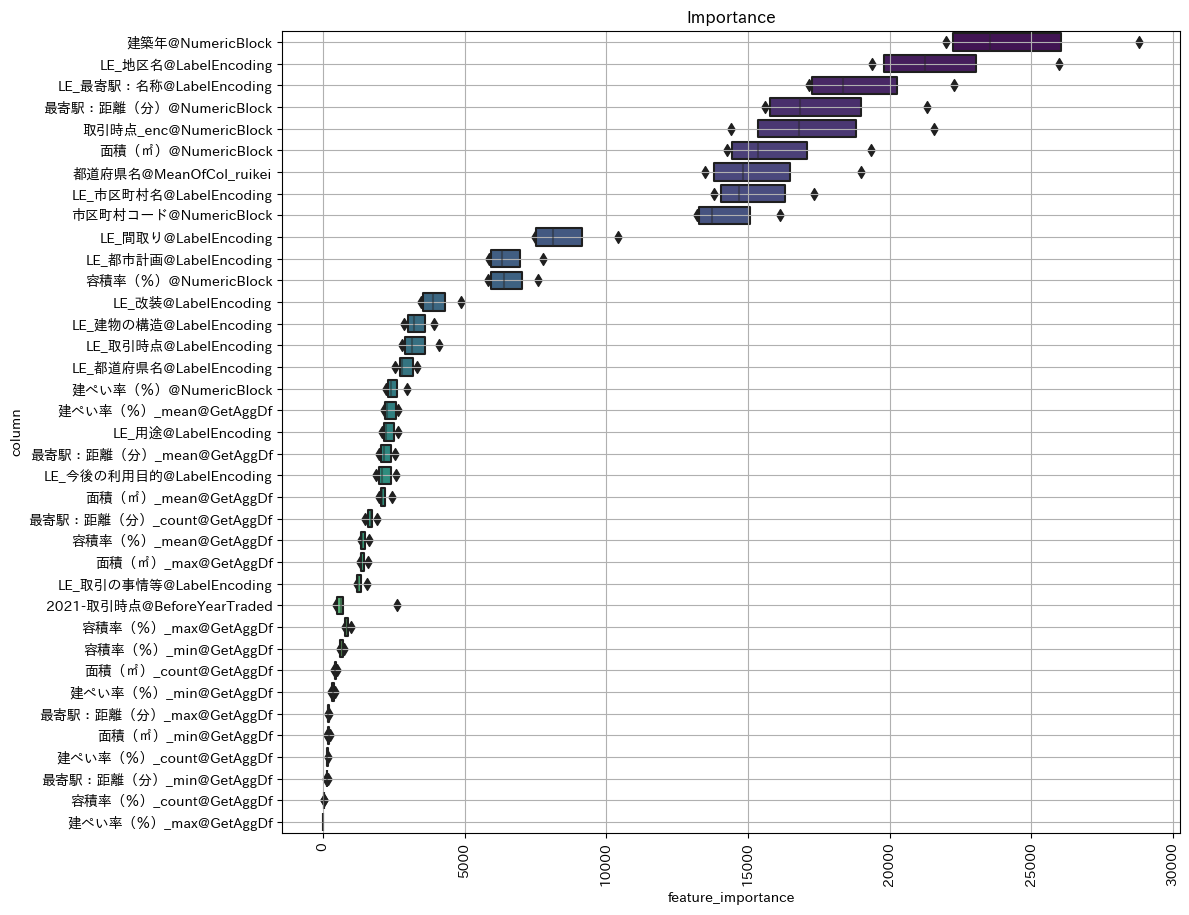

In [40]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:100]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df


fig, ax, fi_df = visualize_importance(models, train_feat_df)

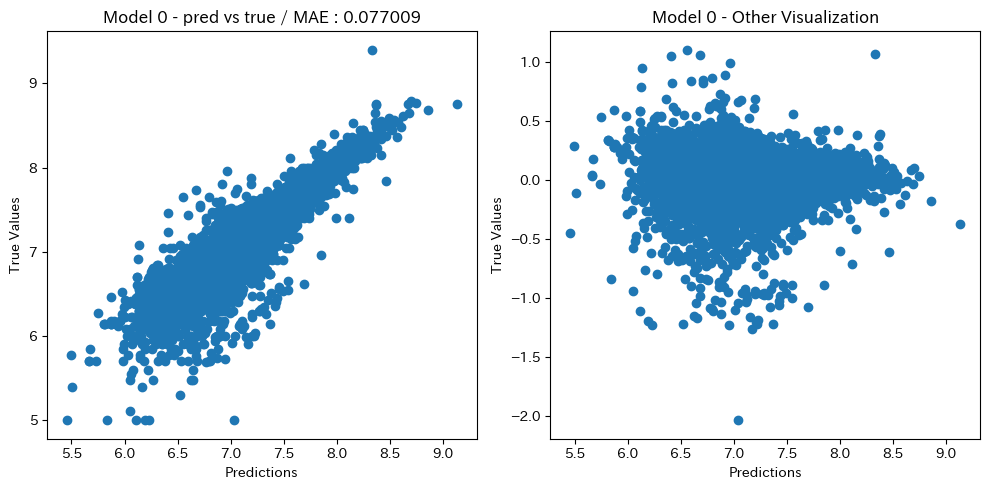

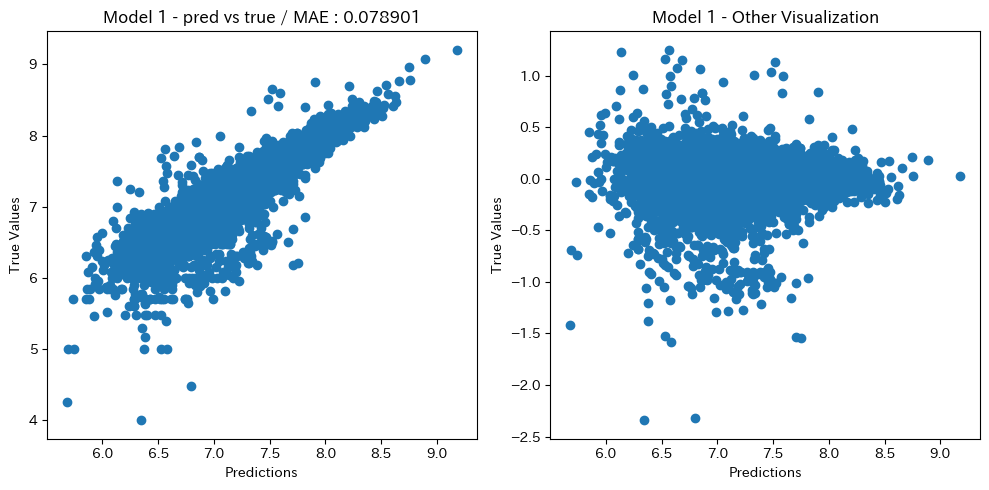

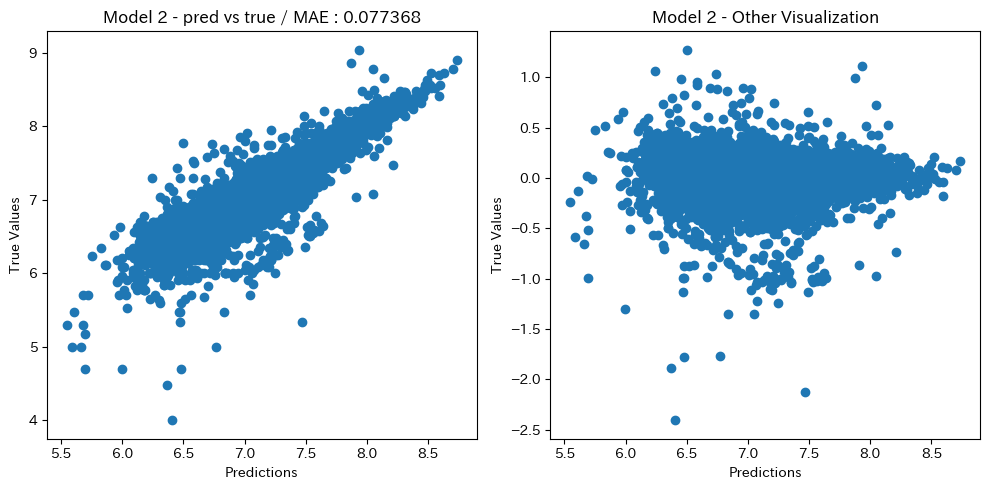

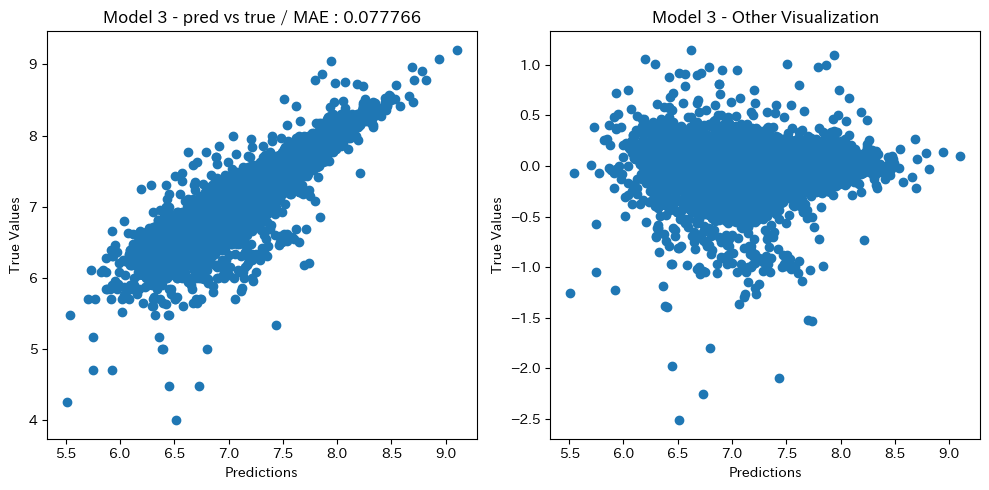

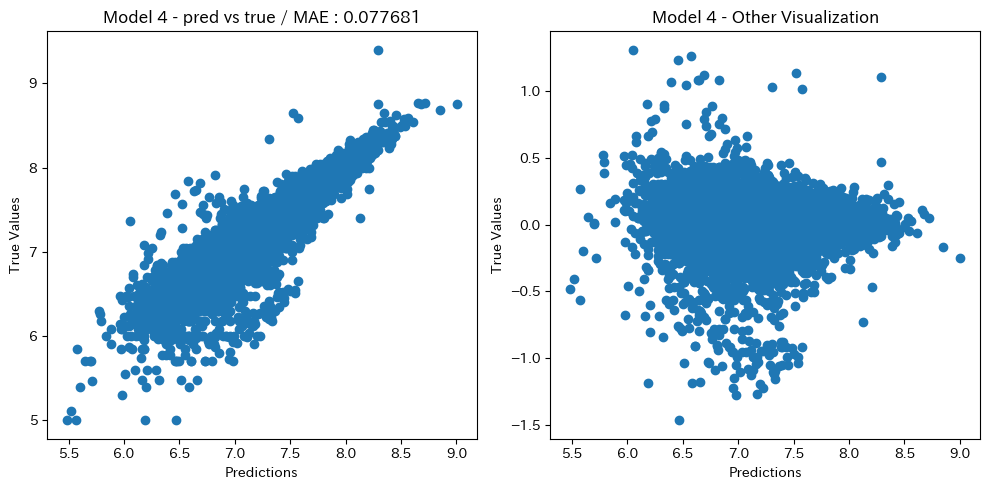

In [41]:
preds = []
for i in range(len(models)):
    valid_idx = cv[i][1]
    pred = models[i].predict(train_feat_df.iloc[valid_idx])
    preds.append(pred)
    
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    
    ax[0].scatter(x=pred, y=y_train[valid_idx])
    ax[0].set_title(f'Model {i} - pred vs true / MAE : {mean_absolute_error(y_train[valid_idx], pred):4f}')
    ax[0].set_xlabel('Predictions')
    ax[0].set_ylabel('True Values')
    
    diff = y_train[valid_idx] - pred
    ax[1].scatter(x=pred, y=diff)
    ax[1].set_title(f'Model {i} - Other Visualization')
    ax[1].set_xlabel('Predictions')
    ax[1].set_ylabel('True Values')
    plt.tight_layout()
    plt.show()

# test dataで推論
trainデータを学習に回して、 testデータに対して推論

In [42]:
# trainで作成した情報でtestの特徴量を生成
test_feat_df = run_blocks(input_df = test_df, blocks=feature_blocks, y=None, test=True)

★★★★★★★★★★★★★★★★★★★★ start run blocks... ★★★★★★★★★★★★★★★★★★★★
	- <__main__.NumericBlock object at 0x7fde8369e250> 0.002[s]
	- <__main__.NumericBlock object at 0x7fde8367b610> 0.002[s]
	- <__main__.NumericBlock object at 0x7fde83325210> 0.002[s]
	- <__main__.NumericBlock object at 0x7fde836a7f10> 0.002[s]
	- <__main__.NumericBlock object at 0x7fde836a6290> 0.001[s]
	- <__main__.NumericBlock object at 0x7fde836a5290> 0.009[s]
	- <__main__.NumericBlock object at 0x7fde836a7190> 0.001[s]
	- <__main__.LabelEncoding object at 0x7fde836a5d90> 0.039[s]
	- <__main__.LabelEncoding object at 0x7fde836a5c10> 0.041[s]
	- <__main__.LabelEncoding object at 0x7fde836a6b90> 0.093[s]
	- <__main__.LabelEncoding object at 0x7fde836a6cd0> 0.046[s]
	- <__main__.LabelEncoding object at 0x7fde836a4b10> 0.033[s]
	- <__main__.LabelEncoding object at 0x7fde836a5bd0> 0.038[s]
	- <__main__.LabelEncoding object at 0x7fde836a6610> 0.037[s]
	- <__main__.LabelEncoding object at 0x7fde836a6f90> 0.037[s]
	- <__main__.La

In [43]:
max_iteration = np.max(models_best_iterations)

# CVのときと比べて増えたデータ数の割合だけ ざっくりだけどiterationの回数も増やすことにする(データ量20%Up → iteration 20%Up)
increase_ratio = (CFG.n_fold / (CFG.n_fold -1))
n_estimators = int(max_iteration * increase_ratio)



In [44]:
# paramsはtrain時のものを使うが、iterationの数はデータ数に必要に応じて修正

max_iteration = np.max(models_best_iterations)

# CVのときと比べて増えたデータ数の割合だけ ざっくりだけどiterationの回数も増やすことにする(データ量20%Up → iteration 20%Up)
increase_ratio = (CFG.n_fold / (CFG.n_fold -1))
n_estimators = int(max_iteration * increase_ratio)


test_params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    "feature_fraction": feature_fraction,
    'subsample_freq': subsample_freq,
    "bagging_fraction": bagging_fraction,
    'min_data_in_leaf': min_data_in_leaf,
    'learning_rate': learning_rate,
    "boosting": boosting,
    "lambda_l1": lambda_l1,
    "lambda_l2": lambda_l2,
    "verbosity": verbosity,
    "random_state": CFG.seed,
    "n_estimators" : n_estimators, # 木の数 default 100
}

In [45]:
max_iteration, n_estimators

(6355, 7943)

In [46]:
test_model = lgbm.LGBMRegressor(**test_params)
test_model.fit(
    train_feat_df.values,
    y_train,
)

LGBMRegressor(bagging_fraction=0.95, boosting='gbdt', feature_fraction=0.8,
              lambda_l1=0.1, lambda_l2=10, max_depth=7, metric='mae',
              min_data_in_leaf=2, n_estimators=7943, num_leaves=42,
              objective='regression', random_state=42, subsample_freq=1,
              verbosity=-1)

In [47]:
test_preds = test_model.predict(test_feat_df)
test_df[CFG.TARGET] = test_preds
train_preds = test_model.predict(train_feat_df)
train_all_df['whole preds'] = train_preds
print(f'{mean_absolute_error(y_train, train_preds):4f}')

0.062405


In [48]:
print(f'{mean_absolute_error(y_train, train_preds):4f}')

0.062405


In [49]:
sub_df = pd.read_csv(os.path.join(CFG.INPUT_DIR, 'sample_submission.csv'))
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', CFG.TARGET]], on='ID')

sub_df.to_csv(
    os.path.join(CFG.OUTPUT_DIR, CFG.exp_folder_name, f'{CFG.exp_name}.csv'),
    index = False,
    header=True
    )

In [50]:
sub_df

,ID,取引価格（総額）_log
0,1000077,7.848104
1,1000129,6.740838
2,1000130,7.131589
3,1000132,7.100564
4,1000133,6.621935
...,...,...
18389,47005079,6.725401
18390,47005148,6.548632
18391,47005227,6.620081
18392,47012107,7.521804


# ↓↓ T.B.D

In [ ]:
# seedを変えたモデルでアンサンブルして、estimatorsが過剰になったとしても悪化を最小限にしたい 参考https://note.com/currypurin/n/n7bd3153a7238
# test_params['seed'] = 42
# test_model2 = lgbm.LGBMRegressor(**test_params)
# test_model2.fit(
#     train_feat_df.values,
#     y_train,
# )

In [ ]:
# pred = test_model2.predict(test_feat_df)
# y_true = test_df[y_col]

# print(f'test data RMSE {np.sqrt(mean_squared_error(y_true, pred))}')
# print(f'test data R2 score {r2_score(y_true, pred)}')